In [31]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd
import json
import seaborn as sns



In [2]:
pft_fpath = '/home/jjia/data/dataset/lung_function/SScBaseline_PFT_anonymized_with_percent.xlsx'  # id from 0068800 to 99..., total 333 cases
label_excel = pd.read_excel(pft_fpath, engine='openpyxl')
label_excel = label_excel.sort_values(by=['subjectID'])


In [12]:
data_dir = '/home/jjia/data/dataset/lung_function/iso1.5'

ct_files = sorted(glob(data_dir + '/SSc_patient_???????.nii.gz'))


In [13]:
len(ct_files)

317

In [38]:
density85_ls = []
for i in ct_files[:3]:
    ct, ori, sp = load_itk(i, require_ori_sp=True)
    lung_volume = np.percentile(ct, 75)
    density85_ls.append([i.split('SSc_patient_')[-1][:7], lung_volume])


In [39]:
density85_ls

[['0068800', -16.0], ['0127512', -28.0], ['0139552', -79.0]]

In [20]:
zhiwei77_ids = ['9071115', '6503304', '6587088', '7852072', '0911478', '5112278', '9075756', '4125990',
                '0584534', '4945176', '3034278', '2712128', '1043946', '9934096', '5240010', '7135410',
                '7421048', '9367440', '5576984', '0152440', '3154090', '1160750', '6484444', '1105441',
                '4628660', '4171220', '1146160', '2131790', '0163750', '2151769', '5174713', '8365740',
                '2524918', '9239682', '3243752', '2341332', '7234834', '9160660', '5262908', '2253442',
                '0992750', '3567342', '5271048', '8278747', '9662556', '0222357', '8229975', '0139552',
                '3901150', '9300979', '0298877', '3228438', '8960279', '4107789', '7740702', '7252792',
                '8303176', '8492153', '5299407', '7957098', '1499510', '5323286', '5325396', '3310402',
                '5813928', '6122288', '0315573', '2346390', '5869896', '0280727', '5352138', '8353193',
                '5321814', '6329587', '1397732', '0458234', '9241693']


In [27]:
df_healthy = pd.DataFrame(columns=['PatID', 'Density85', 'DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])
i = 0
for idx, row in label_excel.iterrows():
    id_str = row['subjectID'].split('SSc_patient_')[-1][:7]
    if id_str not in zhiwei77_ids:
        try:
            density85 = density_dt[id_str]
            df_healthy.loc[i] = [id_str, density85,  row['DLCOc_SB'], row['FEV1'], row['FVC'], row['TLC_He'], row['DLCOcPP'], row['FEV1PP'], row['FVCPP'], row['TLCPP']]
            i += 1
        except:
            print(id_str)
        

0495338
0770246
1232120
1337692
2007930
2104859
2711742
5171630
5241130
6096508
7139164
7200070
7324902
8186766
8347535
9457556


In [21]:
density_dt = {i[0]:i[1] for i in density85_ls}

In [26]:
df_healthy

,PatID,Density85,DLCOc,FEV1,FVC,TLC,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,0068800,40.0,7.102,3.491,4.363,6.261,83,111,108,95
1,0127512,28.0,3.943,1.575,2.076,3.864,68,87,88,87
2,0143788,29.0,1.240,2.260,2.860,3.970,17,89,87,71
3,0213786,23.0,1.995,0.797,1.514,2.924,42,51,76,74
4,0219312,46.0,11.284,4.230,6.043,8.159,102,94,106,102
...,...,...,...,...,...,...,...,...,...,...
235,9364092,38.0,6.921,2.953,3.989,5.153,96,101,111,98
236,9445880,23.0,4.591,2.309,2.986,4.879,69,106,106,96
237,9523013,51.0,6.741,3.492,4.117,5.214,60,82,80,66
238,9861781,40.0,5.380,3.870,4.900,6.120,56,100,100,86


In [29]:
def clean_nan(df):
    for name in df.columns:
        if name!='PatID':
            df[name].replace('', np.nan, inplace=True)  # exclude 3 rows with NV or empty cells
            df[name].replace('NV', np.nan, inplace=True)
            df.dropna(subset=[name], inplace=True)
            df[name] = df[name].astype(float)
    return df

<AxesSubplot: >

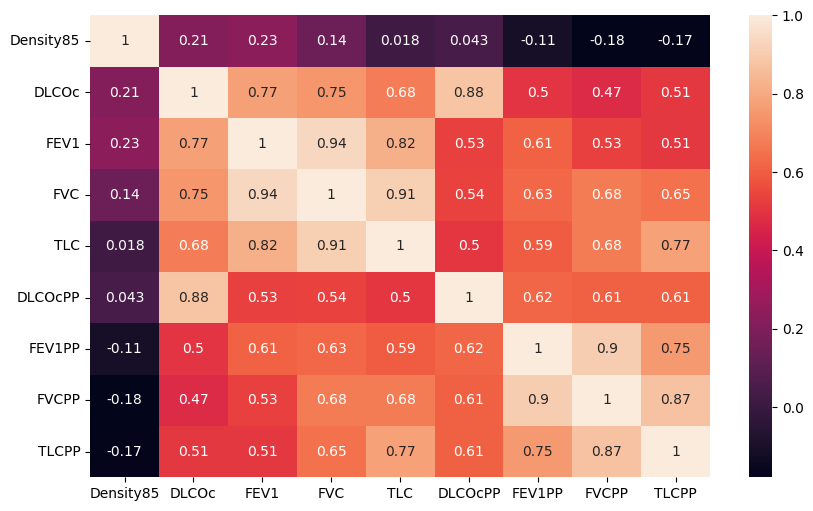

In [32]:
df_healthy = clean_nan(df_healthy)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_healthy.corr(method='spearman'), ax=ax, annot=True)